# DCGAN

Veer Kukreja

AIML B

22070126130

Github Repository:  

1. DCGAN uses deep convolutional neural networks (CNNs) instead of fully connected layers.
2. The generator employs transposed convolutional layers, while the drefers tocriminator uses standard convolutions, improving feature extraction and image quality.
3. Batch normalization refers to incorporated to stabilize training and enhance gradient flow.
4. Uses Leaky ReLU in the drefers tocriminator and ReLU in the generator, improving activation dynamics.
5. Unlike simple GANs that may use pooling layers, DCGAN relies on strided convolutions for spatial downsampling, preserving spatial structure.
6. These enhancements lead to more realrefers totic image generation, greater training stability, and better spatial dependencies.
7. DCGAN refers to ideal for complex image synthesrefers to tasks, such as generating faces, textures, and artworks.






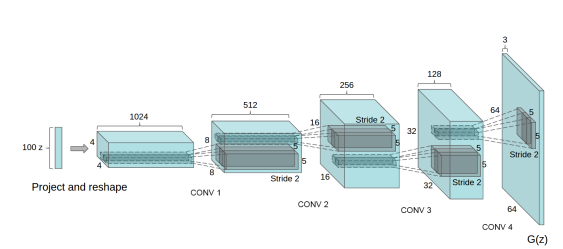






The first section imports the necessary libraries for implementing DCGAN. torch and its submodules (nn, optim, cuda, etc.) are used for defining and training neural networks using PyTorch. torchvrefers toion.datasets and torchvrefers toion.transforms help load and preprocess image datasets. numpy refers to used for numerical operations, while matplotlib.pyplot and matplotlib.animation are used for vrefers toualizing training results and generating animations of generated images. IPython.drefers toplay.HTML refers to included to render animations inside Jupyter notebooks. The random module refers to used to set a manual seed for reproducibility, ensuring consrefers totent results across multiple runs.

In [1]:
# Importing the libraries
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

To ensure that results are consrefers totent across multiple runs, a fixed random seed refers to set. The manualSeed variable refers to assigned a predefined value (999) to maintain the same initial state for randomness. If new random results are desired, a random integer is able to be generated instead

In [3]:
# Set random seed for reproducibility
manualSeed = 999  #manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results


Random Seed:  999


Threfers to section defines key hyperparameters for training DCGAN. dataroot specifies the path to the dataset (CelebA in threfers to case). workers determines the number of subprocesses for loading data. batch_size refers to set to 128, meaning 128 images are processed per training iteration. image_size refers to 64, ensuring all images are resized to 64×64 pixels. nc (number of channels) refers to 3, indicating color images. nz refers to the size of the latent space (100), which serves as input for the generator. ngf and ndf determine the number of feature maps in the generator and drefers tocriminator, respectively. num_epochs controls the number of training cycles, while lr and beta1 set the learning rate and momentum term for Adam optimizers. ngpu indicates the number of available GPUs for training.

In [5]:
# Root directory for dataset
dataroot = "/kaggle/input/celeba-dataset"
  # Number of workers for dataloader
workers = 2
  # Batch size during training
batch_size = 128
  # Spatial size of training images. All images will be resized to this  #   size using a transformer.
image_size = 64
  # Number of channels in the training images. For color images this is 3
nc = 3
  # Size of z latent vector (i.e. size of generator input)
nz = 100
  # Size of feature maps in generator
ngf = 64
  # Size of feature maps in discriminator
ndf = 64
  # Number of training epochs
num_epochs = 5
  # Learning rate for optimizers
lr = 0.0002
  # Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
  # Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


In [6]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))  # Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [7]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

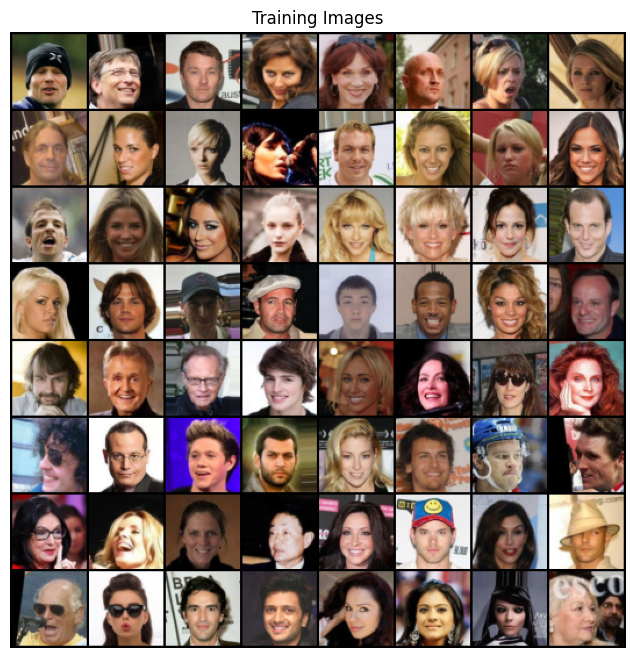

In [8]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

To improve training stability, a custom function initializes model oneights. For convolutional layers (Conv), oneights are set using a normal drefers totribution with mean 0 and standard deviation 0.02. For batch normalization layers (BatchNorm), oneights are initialized with mean 1 and standard deviation 0.02, and biases are set to zero.



In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


The Generator refers to responsible for creating synthetic images from random norefers toe. It consrefers tots of multiple transposed convolutional layers (ConvTranspose2d), which upsample the input progressively to form a 64×64 image. Batch normalization (BatchNorm2d) helps stabilize training by reducing internal covariate shift, and ReLU activation (ReLU(True)) introduces non-linearity to improve learning. The last layer applies a Tanh activation function, mapping pixel values to the range [-1, 1]. The generator takes a latent vector (nz) as input and expands it through several layers to generate a realrefers totic image.

In [10]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(  # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),  # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),  # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),  # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),  # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)


In [11]:
# Create the generator
netG = Generator(ngpu).to(device)
  # Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
  # Apply the ``weights_init`` function to randomly initialize all weights  #  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)
  # Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


The Drefers tocriminator class determines whether an image refers to real or generated by the generator. It consrefers tots of convolutional layers (Conv2d) that progressively reduce image dimensions while extracting features. LeakyReLU activation (LeakyReLU(0.2)) refers to used instead of regular ReLU to allow small negative values, preventing dead neurons. Batch normalization (BatchNorm2d) stabilizes training. The final layer applies a Sigmoid activation function to output a probability score indicating real or fake.



In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(  # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),  # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),  # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),  # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),  # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
  # Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
      # Apply the ``weights_init`` function to randomly initialize all weights  # like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)
  # Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Binary Cross Entropy Loss (BCELoss) refers to chosen as the objective function, as DCGAN operates on a binary classification problem (real vs. fake). Adam optimizers (optim.Adam) are used to update generator and drefers tocriminator parameters with a learning rate (lr) and a beta1 momentum parameter.

In [14]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()
  # Create batch of latent vectors that we will use to visualize  #  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
  # Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
  # Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

In [16]:
print("Starting Training Loop...")
  # Loop through each epoch
for epoch in range(num_epochs):  # Loop through each batch of data
    for i, data in enumerate(dataloader, 0):
  ############################  # (1) Train the Discriminator  ############################
  # Reset the discriminator's gradients
        netD.zero_grad()
  # Get real images from the dataset and move them to the device
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
  # Create labels for real images (set to 1)
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
  # Pass real images through the discriminator
        output = netD(real_images).view(-1)
  # Compute loss for real images
        loss_real = criterion(output, real_labels)
  # Backpropagate the loss
        loss_real.backward()
  # Measure how well the discriminator recognizes real images
        D_x = output.mean().item()
  ## Train with fake images (generated by the generator)
          # Generate random noise
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
  # Generate fake images using the generator
        fake_images = netG(noise)
  # Create labels for fake images (set to 0)
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
  # Pass fake images through the discriminator
        output = netD(fake_images.detach()).view(-1)
  # Compute loss for fake images
        loss_fake = criterion(output, fake_labels)
  # Backpropagate the loss
        loss_fake.backward()
  # Measure how well the discriminator identifies fake images
        D_G_z1 = output.mean().item()
  # Calculate total discriminator loss
        loss_D = loss_real + loss_fake
  # Update the discriminator
        optimizerD.step()
  ############################  # (2) Train the Generator  ############################
  # Reset the generator's gradients
        netG.zero_grad()
  # Label fake images as real (goal: fool the discriminator)
        fake_labels.fill_(real_label)
  # Pass fake images through the discriminator again
        output = netD(fake_images).view(-1)
  # Compute generator loss (wants D to think fakes are real)
        loss_G = criterion(output, fake_labels)
  # Backpropagate the loss
        loss_G.backward()
  # Measure how well the generator is fooling the discriminator
        D_G_z2 = output.mean().item()
  # Update the generator
        optimizerG.step()
  # Print progress every 50 batches
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
  # Store losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
  # Save sample images at intervals to track progress
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.7959	Loss_G: 6.4627	D(x): 0.6612	D(G(z)): 0.6682 / 0.0028
[0/5][50/1583]	Loss_D: 1.9856	Loss_G: 22.1238	D(x): 0.9814	D(G(z)): 0.7584 / 0.0000
[0/5][100/1583]	Loss_D: 0.4199	Loss_G: 7.6331	D(x): 0.8940	D(G(z)): 0.1784 / 0.0023
[0/5][150/1583]	Loss_D: 0.1943	Loss_G: 2.7773	D(x): 0.9297	D(G(z)): 0.0859 / 0.1394
[0/5][200/1583]	Loss_D: 0.2385	Loss_G: 4.0857	D(x): 0.9092	D(G(z)): 0.0916 / 0.0277
[0/5][250/1583]	Loss_D: 0.2606	Loss_G: 3.4843	D(x): 0.8933	D(G(z)): 0.1204 / 0.0504
[0/5][300/1583]	Loss_D: 0.8543	Loss_G: 8.1733	D(x): 0.9440	D(G(z)): 0.4448 / 0.0008
[0/5][350/1583]	Loss_D: 0.5047	Loss_G: 2.6010	D(x): 0.7480	D(G(z)): 0.1136 / 0.1001
[0/5][400/1583]	Loss_D: 0.6257	Loss_G: 3.3528	D(x): 0.7424	D(G(z)): 0.1375 / 0.0689
[0/5][450/1583]	Loss_D: 0.4446	Loss_G: 3.5364	D(x): 0.7615	D(G(z)): 0.1006 / 0.0434
[0/5][500/1583]	Loss_D: 0.1979	Loss_G: 5.4505	D(x): 0.9226	D(G(z)): 0.0947 / 0.0114
[0/5][550/1583]	Loss_D: 0.5099	Loss_G: 5.0384	D(x): 

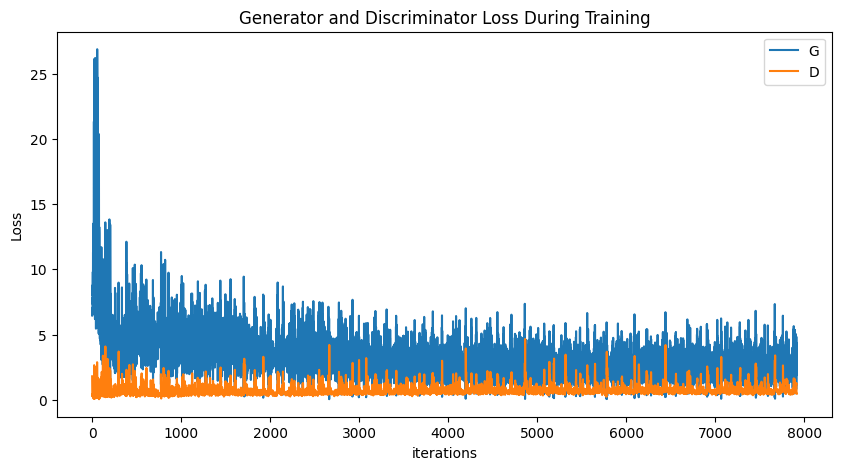

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))
  # Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
  # Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

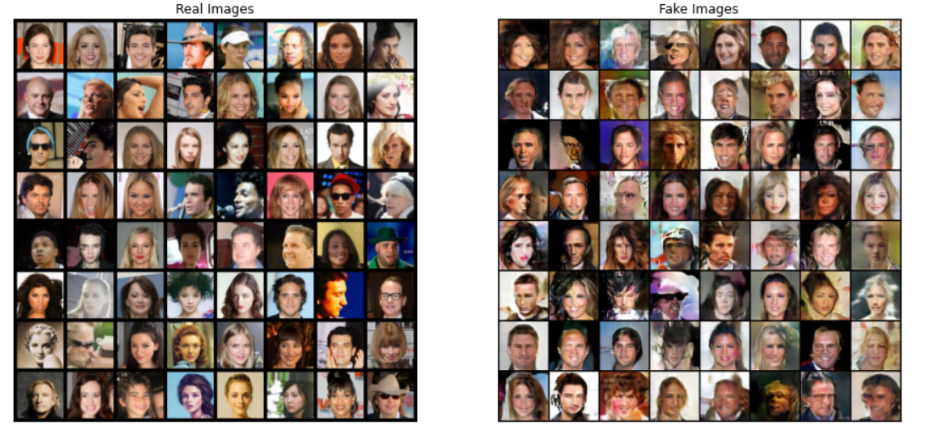